In [92]:
import pickle
import pandas as pd
import urllib.request
import json
import math 
import re
from itertools import islice
from urllib.parse import quote 

In [97]:
# 1. Load names/wiki links dictionary
dc = pickle.load( open( "dc.pkl", "rb" ) )
marvel = pickle.load( open( "marvel.pkl", "rb" ) )

# 2. Extract name / wiki link

def clearDataset(dataset):
    
    wiki_links_n = {}
    
    for i in range(len(dataset)):
        single_link = dataset['WikiLink'].iloc[i]
        single_name = dataset['CharacterName'].iloc[i]        
        
        if(isinstance(single_link, float)):
            continue
        wiki_links_n[single_name] = single_link.replace(" ", "_")
    
    return wiki_links_n

#print(clearDataset(marvel))
marvel_cleaned_data_dir = clearDataset(marvel.head())
dc_cleaned_data_dir = clearDataset(dc)

In [132]:
# 3. create URL with given character_wiki_link
# @returns NAME-> URL dict
def createURLs(data_dir): 
    
    url_query_list = {}
    
    for name,wiki in data_dir.items():
        
        character_wiki_link = data_dir[name]
        
        baseurl = "https://en.wikipedia.org/w/api.php?"
        action = "action=query"
        title = "titles=" + character_wiki_link
        content = "prop=revisions&rvprop=content"
        only_links = "prop=links&pllimit=max"
        dataformat ="format=json"
        
        query = "{}{}&{}&{}&{}&{}".format(baseurl, action, content, title,only_links, dataformat)
        url_query_list[name] = query
        
    
    return url_query_list

url_query_directory = createURLs(marvel_cleaned_data_dir)
#print(url_query_directory)

In [157]:
# 3.1 create URL with given character_wiki_link
# @returns NAME-> URL dict
def createURLsPages(data_dir): 
    
    url_query_list = {}
    
    for name,wiki in data_dir.items():
        
        character_wiki_link = data_dir[name]
        
        baseurl = "https://en.wikipedia.org/w/api.php?"
        action = "action=query"
        title = "titles=" + character_wiki_link
        content = "prop=revisions&rvprop=content"
        only_links = ""
        dataformat ="format=json"
        
        query = "{}{}&{}&{}&{}&{}".format(baseurl, action, content, title,only_links, dataformat)
        url_query_list[name] = query
        
    
    return url_query_list

url_query_directory_pages = createURLsPages(marvel_cleaned_data_dir)


In [158]:
# 4. Send request

def sendWikiRequests(url_list):
    response_wiki_dir = {}
    #z = list(url_list.values())[1]
    #name =  list(url_list.keys())[1]
    
    for name,url in url_list.items():
        #'ascii' codec can't encode character
       ## if 'ñ'in url:
         #   continue
        try:
            wikiresponse = urllib.request.urlopen(url)
            wikidata = wikiresponse.read()
            #print(wikidata)
            wikitext = wikidata.decode('utf-8')
        
        #if (wikitext.strip().startswith("<!DOCTYPE html>")):
            #continue
        
            wiki_json = json.loads(wikitext)
            response_wiki_dir[name] = wiki_json
        except:
            pass
        
    return response_wiki_dir

wiki_json_responses = sendWikiRequests(url_query_directory)

#print(list(wiki_json_responses.values())[0])
#print(type(wiki_json_responses))

print()
x = next(iter( wiki_json_responses.values() ))
#print(x)



In [159]:
# 4.1 Send request for full pages 

def sendWikiRequestsPages(url_list):
    response_wiki_dir = {}
    
    for name,url in url_list.items():
        print(url)
        
        try:
            response = requests.get(url)
            wikisource = response.json()
            pages = wikisource['query']['pages']
            
            for page in pages.keys():
                wikitext = pages[page]['revisions'][0]["*"]   
            print(type(wikitext))
            response_wiki_dir[name] = wikitext
        except:
            pass
        
    return response_wiki_dir

wiki_responses_pages = sendWikiRequestsPages(url_query_directory_pages)
print(wiki_responses)


https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&titles=Abomination_(character)&&format=json
<class 'str'>
https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&titles=Absorbing_Man&&format=json
<class 'str'>
{'Abomination': '{{For|the biblical term|Abomination (Bible)}}\n{{Short description|Marvel Comics fictional character}}\n{{Infobox comics character\n<!--Wikipedia:WikiProject Comics-->\n| image   = Abomination (Emil Blonsky).jpg\n| converted= y\n| caption = Textless cover of \'\'[[Hulk (comic book)|Immortal Hulk]]\'\' #22 (Aug. 2019).<br>Art by [[Ryan Brown (comics)|Ryan Brown]]\n| character_name = Abomination\n| publisher = [[Marvel Comics]]\n| debut   = \'\'[[Tales to Astonish]]\'\' #90 (April 1967)\n| creators = [[Stan Lee]]<br>[[Gil Kane]]\n| alter_ego = Emil Blonsky\n| full_name =\n| species = Human mutate\n| homeworld =\n| alliances =[[KGB]]<br/>[[Advanced Idea Mechanics|A.I.M]]<br/>Legion Accursed<br/>[[Masters of Evil]]<

In [117]:
# Save to file
import os.path

def saveWikiJsonFiles(name_wiki,universe):
    for name,wiki in name_wiki.items():
        print(type(wiki))
        save_path = str(universe)+'/'

        completeName = os.path.join(save_path, name+".txt")      

        with open(completeName, "w") as text_file:
            text_file.write(str(wiki))

In [118]:
saveWikiJsonFiles(wiki_json_responses, 'marvel')

<class 'dict'>
<class 'dict'>


# Part B: Building the networks


In [22]:
def readWikiJsonFiles(name_wiki,universe):
    
    name_wiki_json = {}
    
    for name,wiki in name_wiki.items():
        temp = []
        save_path = str(universe)+'/'
        completeName = os.path.join(save_path, name+".txt") 
        
        with open(completeName, "r") as text_file:
            f = text_file.read()
            print(type(json.loads(json.dumps(str(f)))))
            name_wiki_json[name] = json.loads(json.dumps(f))
    
    return name_wiki_json


In [23]:
name_wiki = readWikiJsonFiles(wiki_json_responses, 'marvel')

<class 'str'>
<class 'str'>


In [25]:

# 5. extractLinks for each title,
# @return array of names(links) to other pages
def extractNodeNeighbors(directory):
    
    linkList = []
    
    for i in range(len(directory)):
        ns = directory[i]['ns']
        if(int(ns) != 0):
            break
        else:
            title = directory[i]['title']
            linkList.append(title)
    
    return linkList

# 5.1 Check if site is redirect
def checkIfRedirect(directory):
    
    
    for i in range(len(directory)):
        ns = directory[i]['ns']
        
        if(int(ns) == 4):
            title = directory[i]['title']
            if "redirect" in title: 
                print('redirect')
                return 0
            else:
                return 1
        else:
            return 1

import ast
# 6. DO preprocessing for each entry
def wiki_json_preprocessing(directory):
    
    name_neighbors = {}
    
    for name,value_json in directory.items():
        value_json = ast.literal_eval(value_json)
        
        non_unique = value_json['query']['pages'].keys()
        non_unique = next(iter(non_unique))
        
        link_dir = value_json['query']['pages'][non_unique]['links']
        #check for redirect
        if(checkIfRedirect(link_dir) == 0):
            del directory[name]
            continue
        else:
            node_neighbors = extractNodeNeighbors(link_dir)
                
        name_neighbors[name] = node_neighbors
        
    return name_neighbors      


In [78]:
marvel_name_nodeLinks = wiki_json_preprocessing(name_wiki)

**For each link you extract, check if the target is a character from your DC/Marvel lists. If yes, keep it. If no, discard it.**

In [79]:
def extractNames(dataset):
    cleaned_data_dir = clearDataset(dataset)
    names_list = []

    for name, link in cleaned_data_dir.items():
        names_list.append(name)
    
    return names_list



In [80]:
dc_list = extractNames(dc)
marvel_list = extractNames(marvel)

In [81]:
def checkFromTargetUniverse(character_nodes, universe):
    return list(set(character_nodes) & set(universe))

In [191]:
# Marvel check
for name, links in marvel_name_nodeLinks.items():
    
    x_dc = checkFromTargetUniverse(links, dc_list)
    
    x_marvel = checkFromTargetUniverse(links, marvel_list)

    x_final = list(set().union(x_dc, x_marvel))
    
    name_nodeLinks[name] = x_final

In [192]:
def connectLinksPages(link_Directory,page_Directory):
    for name, wiki in page_Directory.items():
        print(name)
        link_Directory[name].append('***' + wiki)
    return link_Directory
    

In [193]:
# adding pages content for later NLP 
name_nodeLinks = connectLinksPages (name_nodeLinks, wiki_responses_pages)

Abomination
Absorbing Man


In [196]:
print(name_nodeLinks['Abomination'][1])

Karen Page


In [174]:
print(name_nodeLinks['Abomination'][-1])

***asdasdasdasdasdasdasdsa


#### Use a NetworkX DiGraph to store the network. As noted above, remember to store the properties of the nodes (i.e. from which universe they hail).


In [197]:
# IMPORTS
import networkx as nx

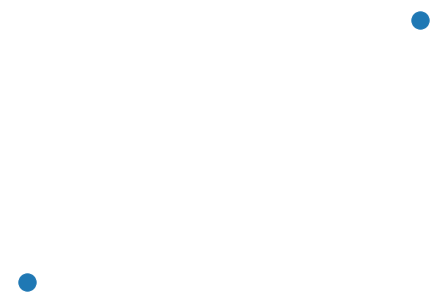

In [198]:
# G.add_node('abc', dob=1185, pob='usa', dayob='monday')

G = nx.DiGraph()

for name,connection in marvel_name_nodeLinks.items():
    G.add_node(name, universe = 'marvel')

nx.draw(G)